In [1]:
# Load data

# CICIDS2017
# 

import os
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from joblib import dump, load
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

df = pd.read_csv('cleaned_df_multilabel.csv')
# df

In [2]:
# Overview of attack type breakdowns

# print(df['Label'].value_counts())
# df.describe()

In [3]:
# Function to group attacks into a larger subset

def attack_type_to_int(row):
    if row['Label'] == 'BENIGN':
        return 0
    elif row['Label'] == 'DDoS':
        return 1
    elif row['Label'][0] == 'D': #Dos attacks
        return 2
    elif row['Label'] == 'PortScan':
        return 3
    elif row['Label'] == 'FTP-Patator': # brute force
        return 4
    elif row['Label'] == 'SSH-Patator': # brute force
        return 5
    elif row['Label'] == 'Bot':
        return 6
    elif row['Label'][0] == 'W': # Web Attack
        return 7
    elif row['Label'] == 'Infiltration':
        return 8
    elif row['Label'] == 'Heartbleed':
        return 9
    else:
        return -1


# def attack_type_to_int(row):
#     if row['Label'] == 'BENIGN':
#         return 0
#     else:
#         return 1

In [4]:
# Replace string values with numerical data

df['attack_type'] = df.apply(lambda row: attack_type_to_int(row), axis=1)
df = df.drop('Label', axis=1)
df['attack_type'].value_counts()

0    2268589
2     251548
3     158804
1     128006
4       7931
5       5895
7       2180
6       1956
8         35
9          7
Name: attack_type, dtype: int64

In [5]:
# Downsample majority class better class balance

df_benign = df[df.attack_type==0]
df_dos = df[df.attack_type==2]
df_portscan = df[df.attack_type==3]
df_ddos = df[df.attack_type==1]
df_minority = df[df.attack_type>3]
 
df_benign_downsampled = resample(df_benign, 
                                 replace=False,    
                                 n_samples=400000,    
                                 random_state=25) 

df_dos_downsampled = resample(df_dos, 
                                 replace=False,   
                                 n_samples=50000,    
                                 random_state=25) 

df_portscan_downsampled = resample(df_portscan, 
                                 replace=False,    
                                 n_samples=50000,    
                                 random_state=25) 

df_ddos_downsampled = resample(df_ddos, 
                                 replace=False,   
                                 n_samples=50000,    
                                 random_state=25)

# df_minority_downsampled = resample(df_minority, 
#                              replace=False,    
#                              n_samples=10000,    
#                              random_state=25) 
 
df_downsampled = pd.concat([df_benign_downsampled, 
                            df_dos_downsampled, 
                            df_portscan_downsampled, 
                            df_ddos_downsampled, 
                            df_minority])
 
df_downsampled['attack_type'].value_counts()

# df_0 = df[df.attack_type==0]
# df_1 = df[df.attack_type==1]

# df_0_downsampled = resample(df_0, 
#                              replace=False,    
#                              n_samples=1000000,    
#                              random_state=25) 

# df_1_downsampled = resample(df_1, 
#                              replace=False,    
#                              n_samples=500000,    
#                              random_state=25) 

# df_downsampled = pd.concat([df_0_downsampled, 
#                             df_1_downsampled])

0    400000
3     50000
2     50000
1     50000
4      7931
5      5895
7      2180
6      1956
8        35
9         7
Name: attack_type, dtype: int64

In [6]:
# Split into train/test the same way done in other two papers


X = df_downsampled.drop(columns=['attack_type'], axis=1)
y = df_downsampled['attack_type']

X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=0.05,
        test_size=0.95,
        random_state=25,
        stratify=y
    )

print(y_train.value_counts())
print(y_test.value_counts())

0    20000
3     2500
2     2500
1     2500
4      396
5      295
7      109
6       98
8        2
Name: attack_type, dtype: int64
0    380000
3     47500
2     47500
1     47500
4      7535
5      5600
7      2071
6      1858
8        33
9         7
Name: attack_type, dtype: int64


In [7]:
y_train = y_train.apply(lambda x: 1 if x > 0 else 0)
y_test = y_test.apply(lambda x: 1 if x > 0 else 0)
print(y_train.value_counts())
print(y_test.value_counts())

0    20000
1     8400
Name: attack_type, dtype: int64
0    380000
1    159604
Name: attack_type, dtype: int64


In [8]:
# X_test.head(20)

In [9]:
# # Do z-scaling for all values that are not already 0-1 and fit it onto the test data as well

scaler = StandardScaler()

cols = list(X_train.columns.values)
cols.remove('Fwd PSH Flags')
cols.remove('Fwd URG Flags')
cols.remove('FIN Flag Count')
cols.remove('SYN Flag Count')
cols.remove('RST Flag Count')
cols.remove('PSH Flag Count')
cols.remove('ACK Flag Count')
cols.remove('URG Flag Count')
cols.remove('CWE Flag Count')
cols.remove('ECE Flag Count')
cols.remove('is_well_known_port')
cols.remove('is_registered_port')

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# dump(scaler, 'std_scaler_cicids17.bin', compress=True)

# X_train.describe()

/Users/davidhan/dev/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/davidhan/dev/ml_env/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/davidhan/dev/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [10]:
# Resample data for running pca and tsne

# df = X.copy(deep=True)
# df['attack_type'] = y

# df_benign = df[df.attack_type==0]
# df_dos = df[df.attack_type==2]
# df_portscan = df[df.attack_type==3]
# df_ddos = df[df.attack_type==1]
# df_4 = df[df.attack_type==4]
# df_5 = df[df.attack_type==5]
# df_6 = df[df.attack_type==6]
# df_7 = df[df.attack_type==7]
# df_minority = df[df.attack_type>7]
 
# df_benign_downsampled = resample(df_benign, 
#                                  replace=False,    
#                                  n_samples=2000,    
#                                  random_state=17) 

# df_dos_downsampled = resample(df_dos, 
#                                  replace=False,   
#                                  n_samples=2000,    
#                                  random_state=17) 

# df_portscan_downsampled = resample(df_portscan, 
#                                  replace=False,    
#                                  n_samples=2000,    
#                                  random_state=17) 

# df_ddos_downsampled = resample(df_ddos, 
#                                  replace=False,   
#                                  n_samples=2000,    
#                                  random_state=17)

# df_4_downsampled = resample(df_4, 
#                                  replace=False,   
#                                  n_samples=2000,    
#                                  random_state=17)

# df_5_downsampled = resample(df_5, 
#                                  replace=False,   
#                                  n_samples=2000,    
#                                  random_state=17)

# df_7_downsampled = resample(df_7, 
#                                  replace=False,   
#                                  n_samples=2000,    
#                                  random_state=17)
 
# df_visualization = pd.concat([df_benign_downsampled, 
#                             df_dos_downsampled, 
#                             df_portscan_downsampled, 
#                             df_ddos_downsampled, 
#                             df_4_downsampled,
#                             df_5_downsampled,
#                             df_6,
#                             df_7_downsampled,
#                             df_minority])
 
# df_visualization['attack_type'].value_counts()


In [11]:
# PCA to see how principal component accounts for variance

# df_visualization_features = df_visualization.drop('attack_type', axis=1)

# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(df_visualization_features.values)
# df_visualization['pca-one'] = pca_result[:,0]
# df_visualization['pca-two'] = pca_result[:,1] 
# df_visualization['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# # Plot 2D PCA

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="attack_type",
#     palette=sns.color_palette("hls", 10),
#     data=df_visualization,
#     legend="full",
#     alpha=0.3
# )

In [12]:
# Plot 3D PCA

# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# graph = ax.scatter(
#     xs=df_visualization["pca-one"], 
#     ys=df_visualization["pca-two"], 
#     zs=df_visualization["pca-three"], 
#     c=df_visualization["attack_type"], 
#     cmap='tab10',
# )
# legend1 = ax.legend(*graph.legend_elements(),
#                     loc="upper left", title="attack_type")
# ax.add_artist(legend1)
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()

In [13]:
# Drop PCA columns before running TSNE

# df_visualization = df_visualization.drop(columns=['pca-one', 'pca-two', 'pca-three'], axis=1)

# # Run TSNE on data
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(df_visualization_features)

# df_visualization['tsne-2d-one'] = tsne_results[:,0]
# df_visualization['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="attack_type",
#     palette=sns.color_palette("hls", 10),
#     data=df_visualization,
#     legend="full",
#     alpha=0.3
# )


In [14]:
# Combine minority classes for better class balance

# y_train = y_train.apply(lambda x: 1 if x > 0 else 0)
# y_test = y_test.apply(lambda x: 1 if x > 0 else 0)

# print(y_train.value_counts())
# print(y_test.value_counts())

In [15]:
# Plot of correlation between features

# f = plt.figure(figsize=(30, 24))
# plt.matshow(X_train.corr(), fignum=f.number)
# plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=10, rotation=90)
# plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=10)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=10)


In [16]:
# corr_matrix = df.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# to_drop_95 = [column for column in upper.columns if any(upper[column] > 0.95)]

# print(to_drop_95)

# # Plot of correlation between features

# X_train_95 = X_train.drop(columns = to_drop_95, axis=1)
# X_test_95 = X_test.drop(columns = to_drop_95, axis=1)


# f = plt.figure(figsize=(30, 24))
# plt.matshow(X_train_95.corr(), fignum=f.number)
# plt.xticks(range(X_train_95.shape[1]), X_train_95.columns, fontsize=10, rotation=90)
# plt.yticks(range(X_train_95.shape[1]), X_train_95.columns, fontsize=10)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=10)

In [17]:
def fit_and_score_ensemble_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    print('Accuracy:', accuracy_score(y_test, y_pred), '\n')
    print(precision_recall_fscore_support(y_test, y_pred), '\n')
    print('F1_score:', f1_score(y_test, y_pred), '\n')
    print(classification_report(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred, normalize='true'), '\n')

    
def plot_feature_importances(model, labels, color):
    values = model.feature_importances_
    index = np.arange(len(labels))
    fig = plt.figure(figsize=(30, 24))
    plt.bar(index, values, color=color)
    plt.xlabel('Feature', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.xticks(index, labels, fontsize=10, rotation=90)
    plt.show()

def export_model(model, filename):
    # Dump to a retrievable file: model = load('filename.joblib') 
    dump(model, filename + '.joblib') 
    # save to Onnx file type
    initial_type = [('float_input', FloatTensorType([None, 70]))]
    onx = convert_sklearn(rf_model, initial_types=initial_type)
    with open(filename + '.onnx', 'wb') as f:
        f.write(onx.SerializeToString())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished


Accuracy: 0.9959544406638943 

(array([0.99623832, 0.99527444]), array([0.99802368, 0.99102779]), array([0.9971302 , 0.99314658]), array([380000, 159604])) 

F1_score: 0.9931465778411249 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380000
           1       1.00      0.99      0.99    159604

    accuracy                           1.00    539604
   macro avg       1.00      0.99      1.00    539604
weighted avg       1.00      1.00      1.00    539604
 

[[379249    751]
 [  1432 158172]] 

[[0.99802368 0.00197632]
 [0.00897221 0.99102779]] 



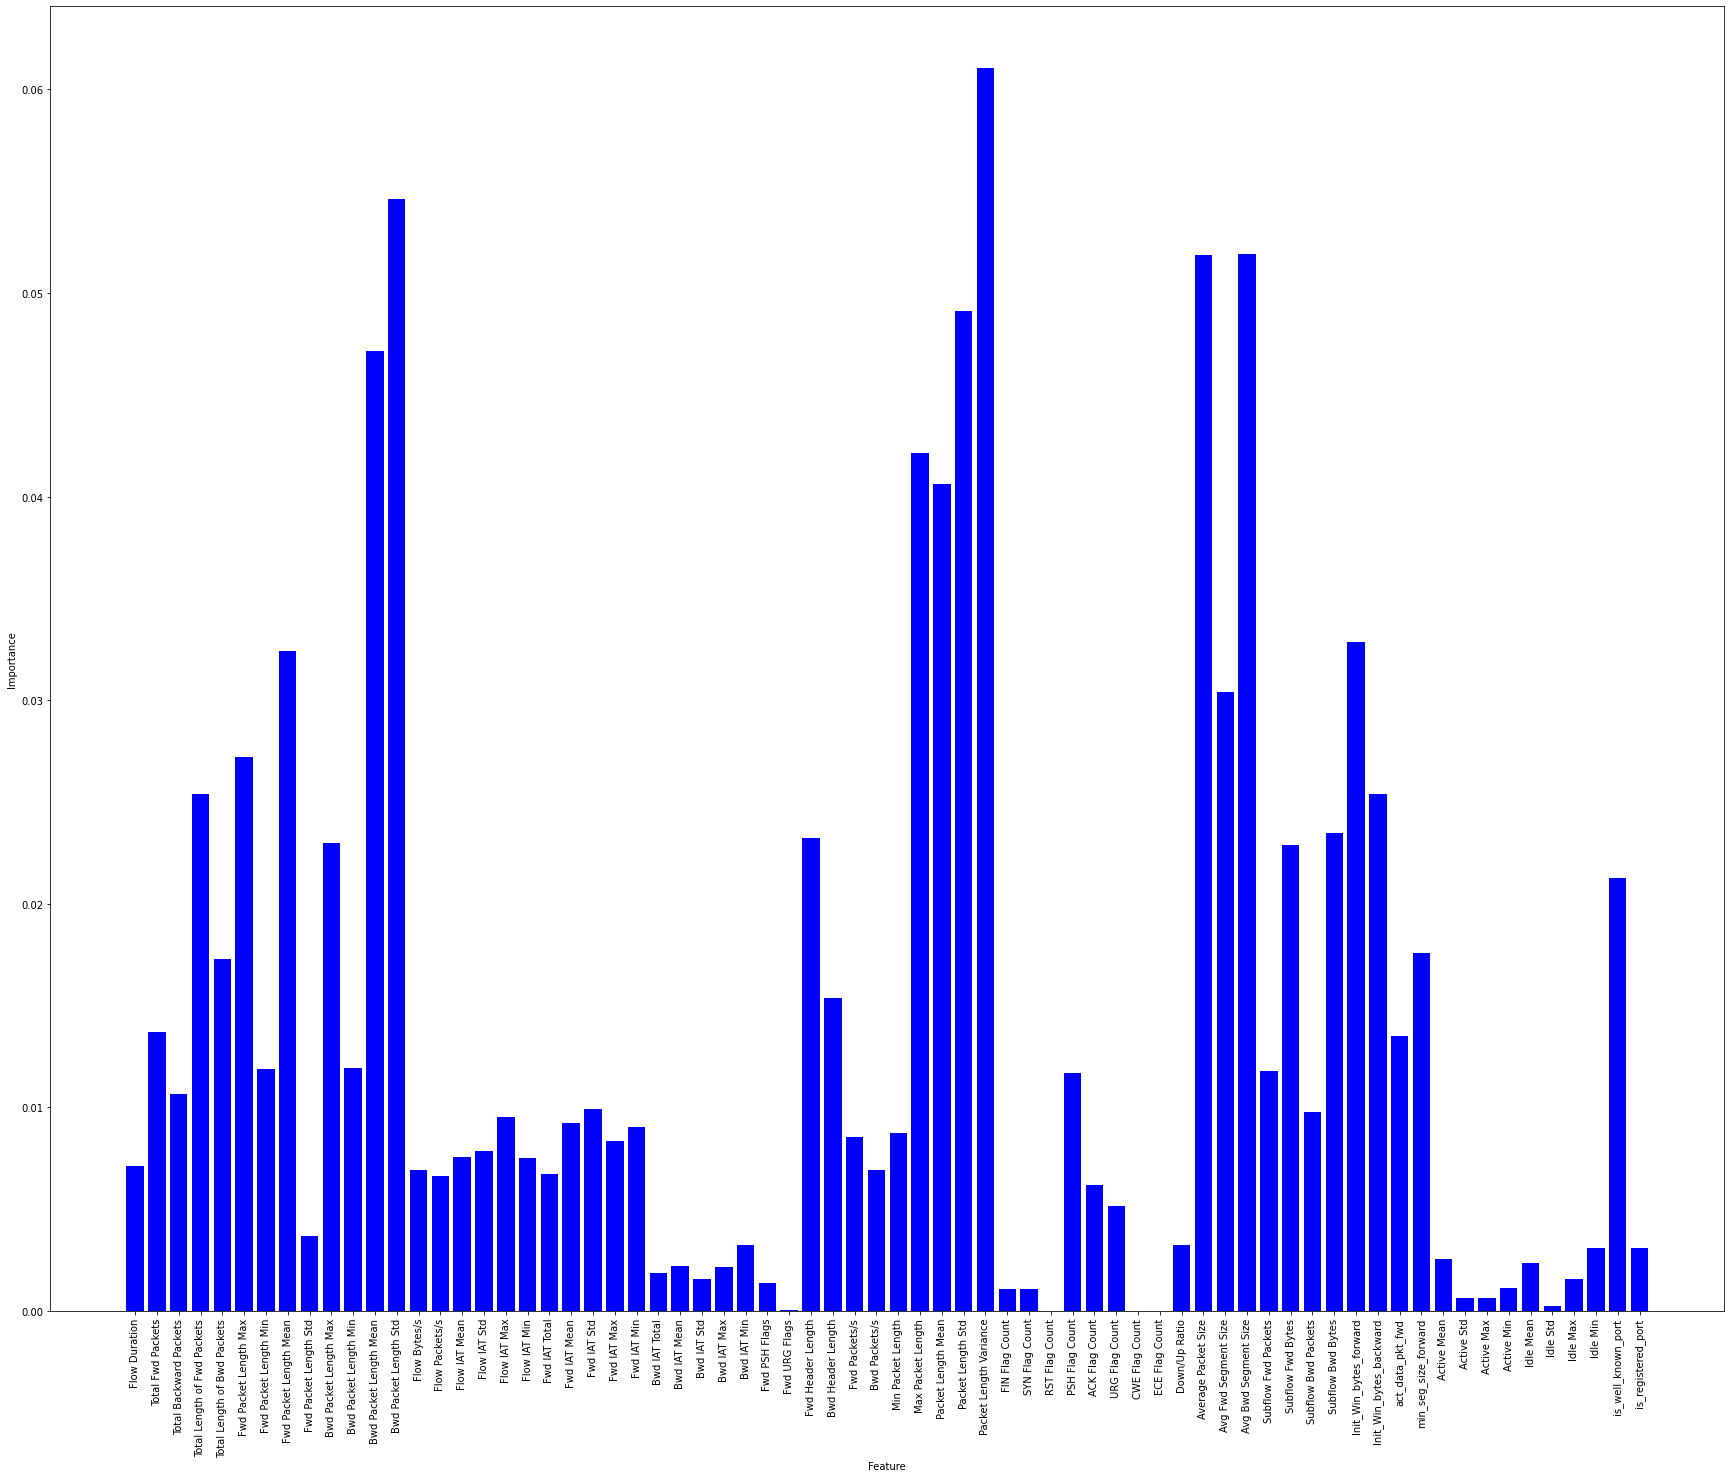

In [18]:
# Random Forest on all columns

rf_model = RandomForestClassifier(n_estimators=100, 
                            bootstrap = True,
                            max_features = 'sqrt',
                            verbose=True,
                            random_state=25)

fit_and_score_ensemble_classifier(rf_model, X_train, y_train, X_test, y_test)
plot_feature_importances(rf_model, X_train.columns, 'blue')


# disp = plot_confusion_matrix(rf_model, X_test, y_test,
#                              cmap=plt.cm.Blues,
#                              normalize='true')
# disp.ax_.set_title('Confusion Matrix for RF')
# disp.confusion_matrix

In [19]:
# Random Forest Classifier on reduced_95 

# rf_model_95 = RandomForestClassifier(n_estimators=100, 
#                             bootstrap = True,
#                             max_features = 'sqrt',
#                             verbose=True,
#                             random_state=25)

# fit_and_score_ensemble_classifier(rf_model_95, X_train_95, y_train, X_test_95, y_test)
# plot_feature_importances(rf_model_95, X_train_95.columns, 'blue')

Accuracy: 0.9979132845568232 

(array([0.99863914, 0.9961865 ]), array([0.99839737, 0.99676073]), array([0.99851824, 0.99647354]), array([380000, 159604])) 

F1_score: 0.9964735358596931 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380000
           1       1.00      1.00      1.00    159604

    accuracy                           1.00    539604
   macro avg       1.00      1.00      1.00    539604
weighted avg       1.00      1.00      1.00    539604
 

[[379391    609]
 [   517 159087]] 

[[0.99839737 0.00160263]
 [0.00323927 0.99676073]] 



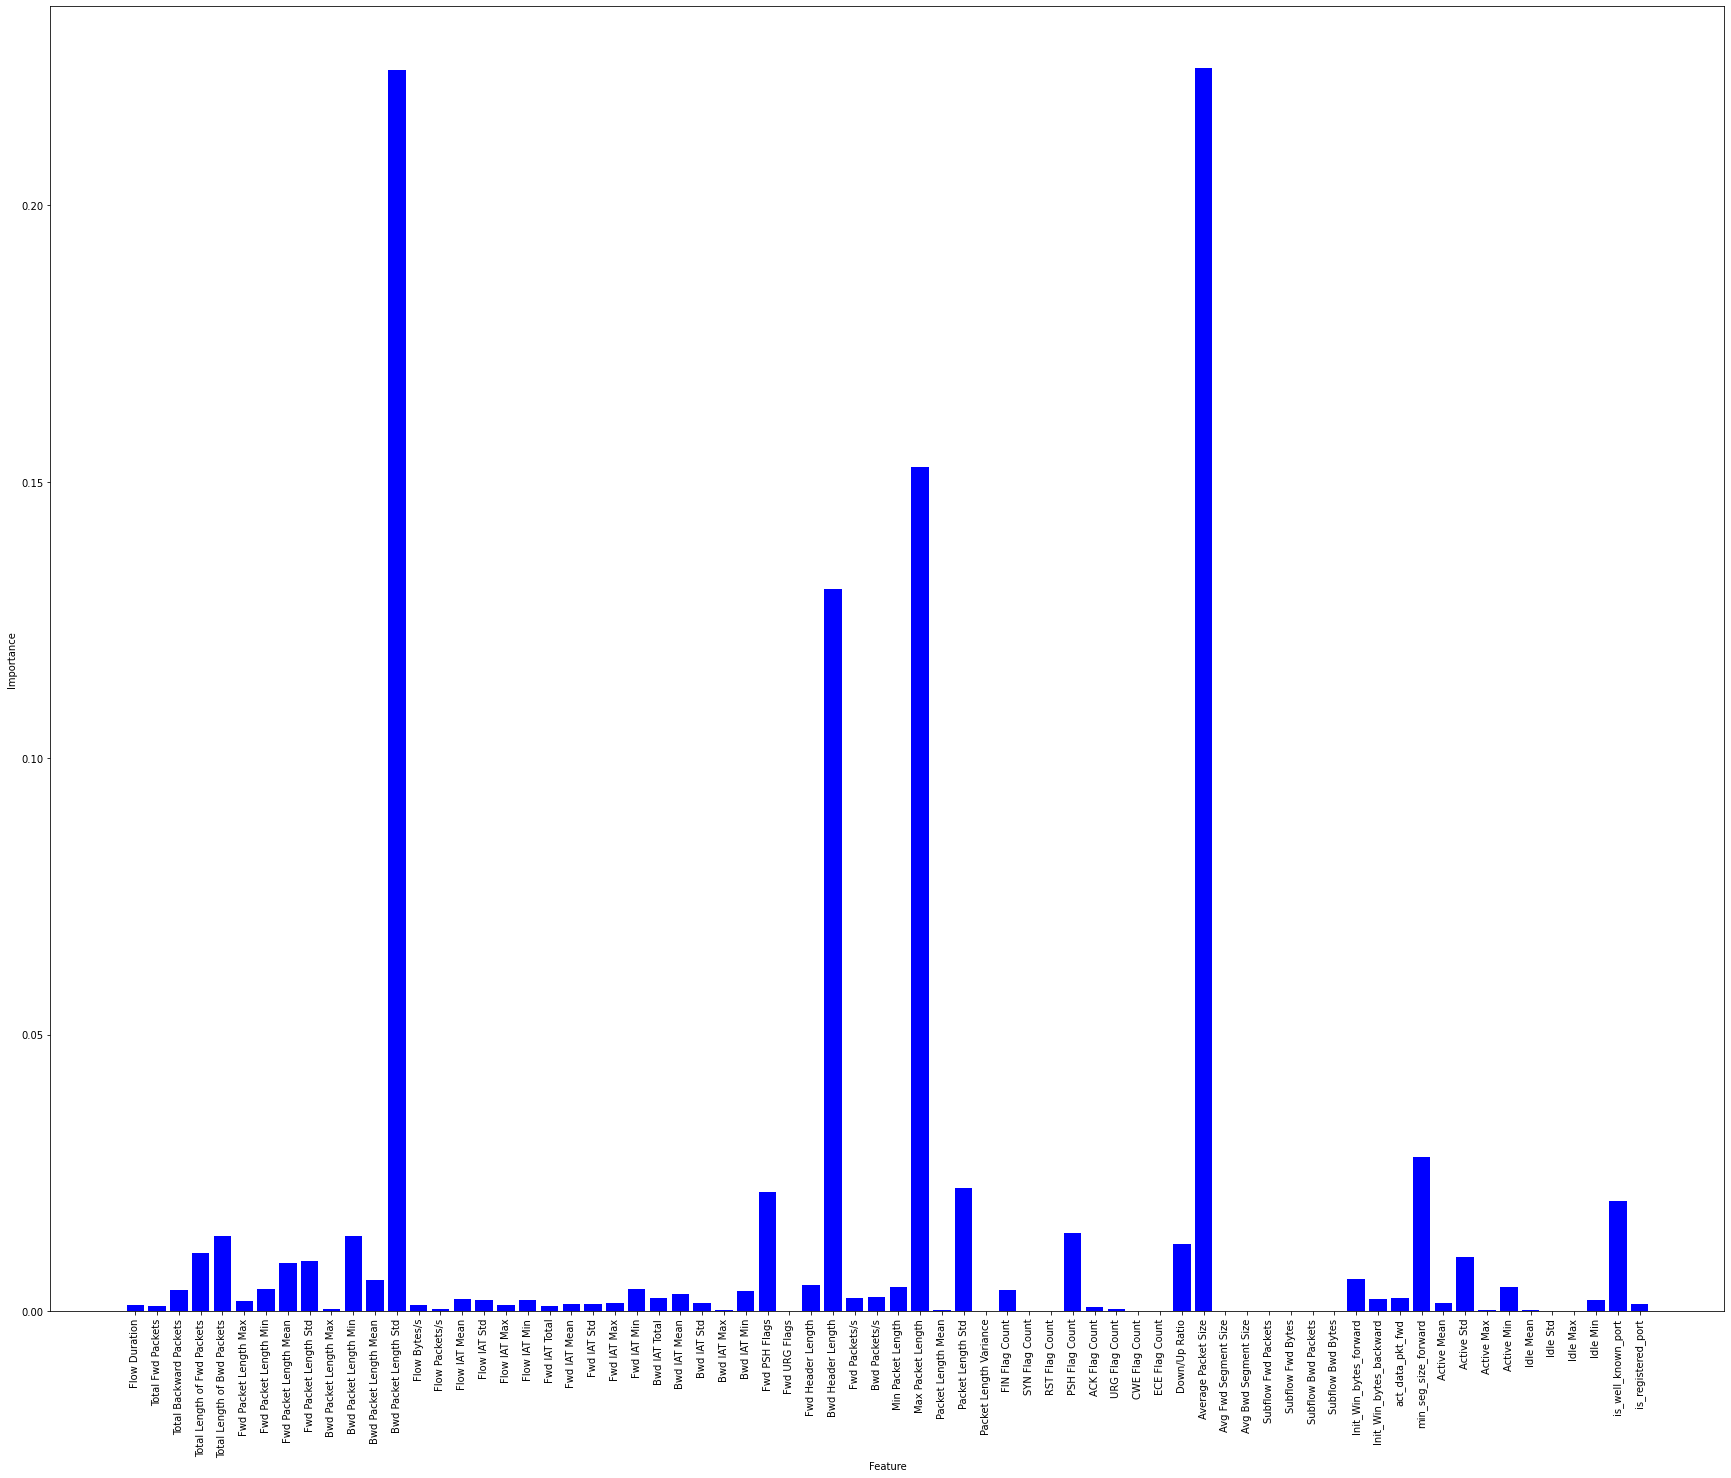

In [20]:
# XGboost in anomaly detection
xgb_model = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

fit_and_score_ensemble_classifier(xgb_model, X_train, y_train, X_test, y_test)
plot_feature_importances(xgb_model, X_train.columns, 'blue')


In [21]:
# XGB on 95 reduced

# xgb_model_95 = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

# fit_and_score_ensemble_classifier(xgb_model_95, X_train_95, y_train, X_test_95, y_test)
# plot_feature_importances(xgb_model_95, X_train_95.columns, 'blue')


Accuracy: 0.9978095047479263 

(array([0.99870984, 0.99566975]), array([0.99817895, 0.9969299 ]), array([0.99844432, 0.99629943]), array([380000, 159604])) 

F1_score: 0.9962994270686578 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380000
           1       1.00      1.00      1.00    159604

    accuracy                           1.00    539604
   macro avg       1.00      1.00      1.00    539604
weighted avg       1.00      1.00      1.00    539604
 

[[379308    692]
 [   490 159114]] 

[[0.99817895 0.00182105]
 [0.0030701  0.9969299 ]] 



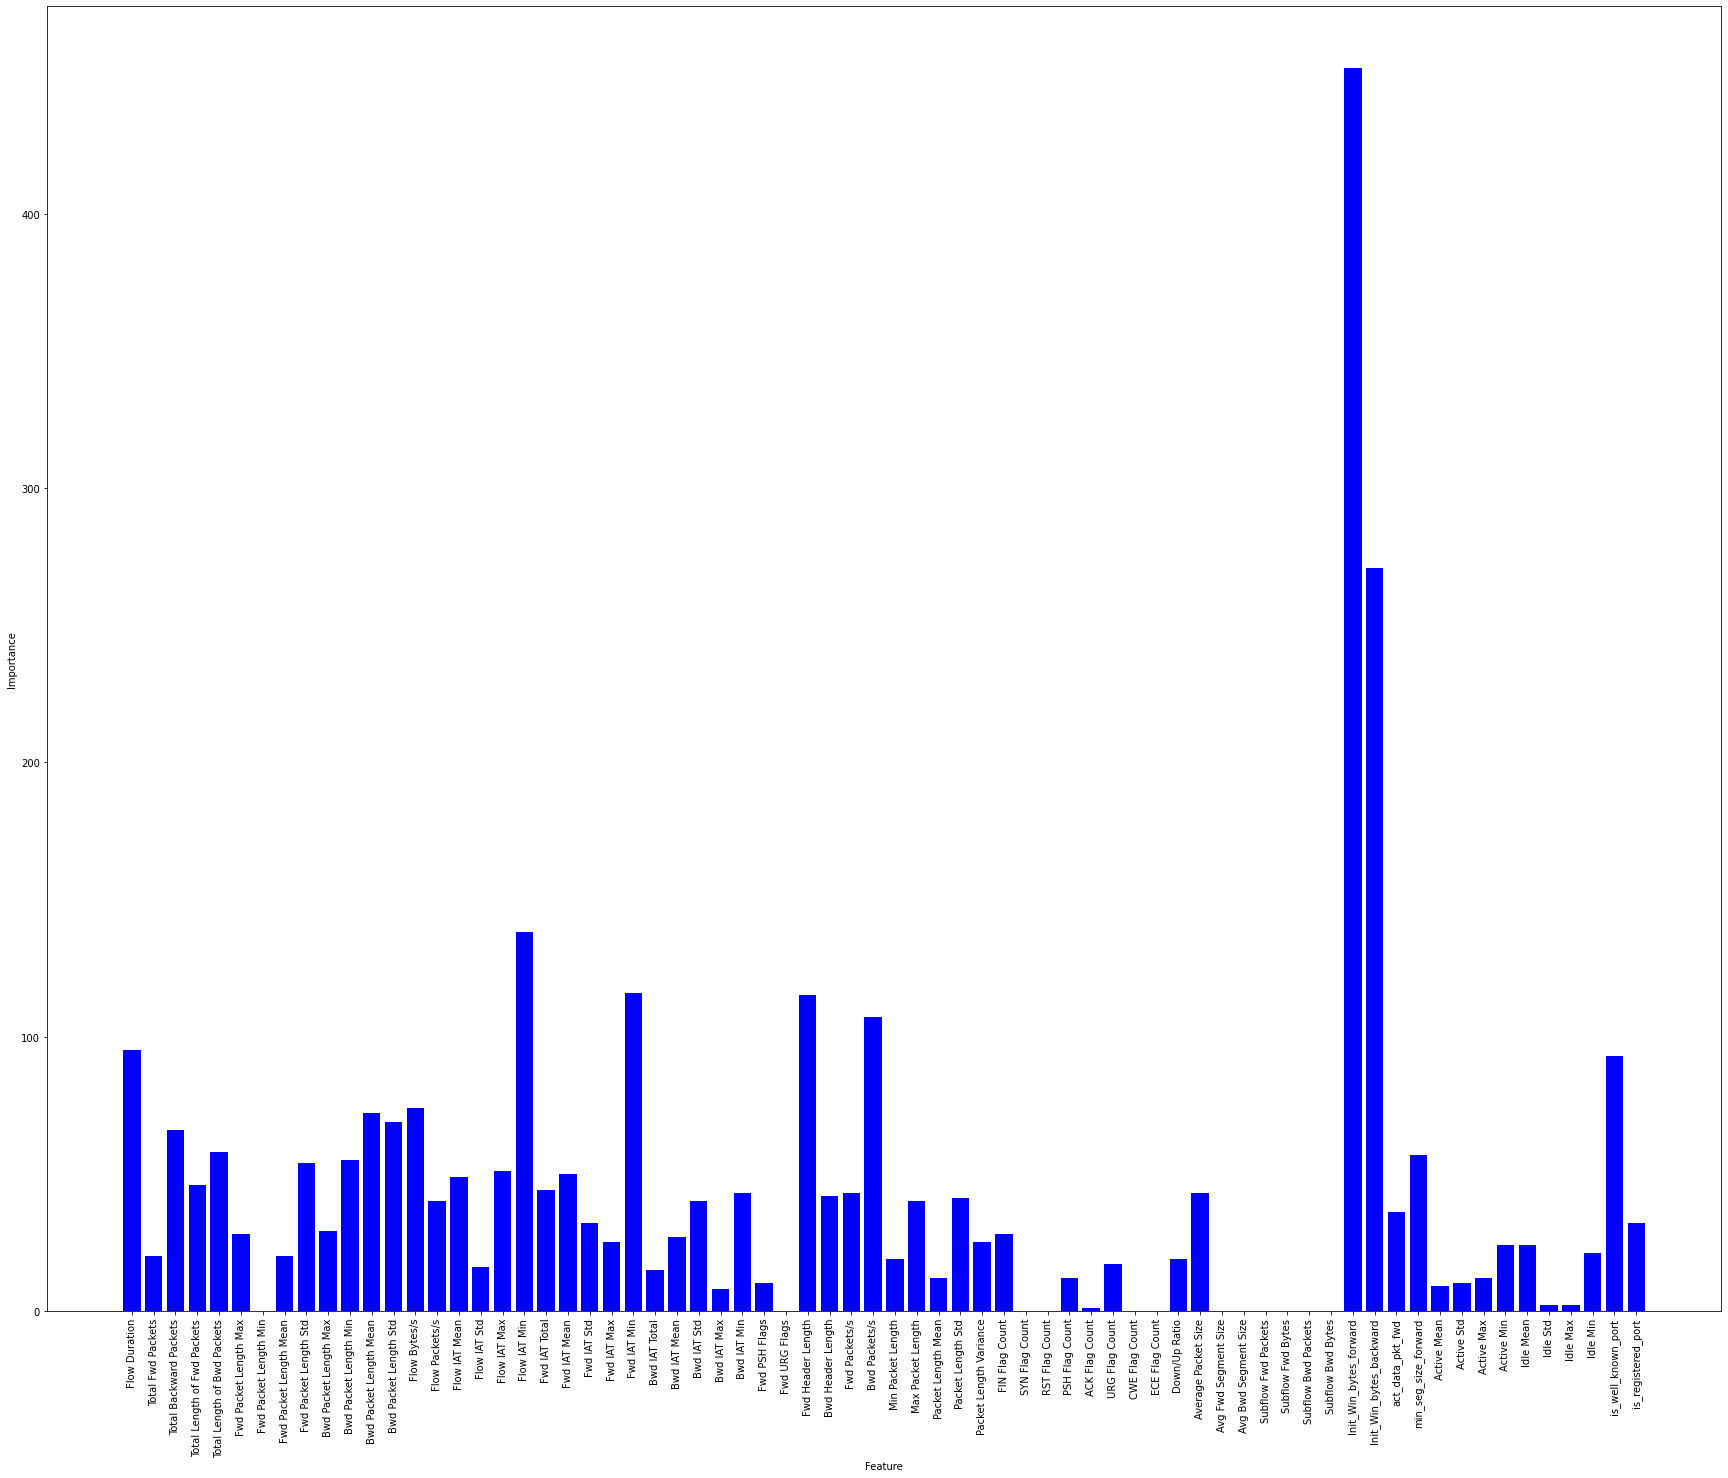

In [22]:
# LGBM on all columns

lgbm_model = LGBMClassifier(silent=False, random_state=25)

fit_and_score_ensemble_classifier(lgbm_model, X_train, y_train, X_test, y_test)
plot_feature_importances(lgbm_model, X_train.columns, 'blue')

In [23]:
# # LGBM on 95 reduced

# lgbm_model_95 = LGBMClassifier(silent=False, random_state=1001)

# fit_and_score_ensemble_classifier(lgbm_model_95, X_train_95, y_train, X_test_95, y_test)
# plot_feature_importances(lgbm_model_95, X_train_95.columns, 'blue')